# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
#export
from exp.nb_04 import *
import functools

<IPython.core.display.Javascript object>

# Initial setup

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7013)

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

<IPython.core.display.Javascript object>

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

<IPython.core.display.Javascript object>

In [5]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

<IPython.core.display.Javascript object>

In [6]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.6600203125, tensor(0.8067)]
valid: [0.30798671875, tensor(0.9128)]
train: [0.28680037109375, tensor(0.9173)]
valid: [0.240789990234375, tensor(0.9320)]
train: [0.2339634765625, tensor(0.9327)]
valid: [0.198992724609375, tensor(0.9464)]


<IPython.core.display.Javascript object>

In [7]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.7627375, tensor(0.8031)]
valid: [0.3784945556640625, tensor(0.8872)]
train: [0.3454766796875, tensor(0.9008)]
valid: [0.302458837890625, tensor(0.9126)]
train: [0.294186640625, tensor(0.9156)]
valid: [0.2596729736328125, tensor(0.9264)]


<IPython.core.display.Javascript object>

In [8]:
#export
def get_model_func(lr=0.5):
    return partial(get_model, lr=lr)

<IPython.core.display.Javascript object>

# Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

In [9]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = []
        self.losses = []

    def after_batch(self):
        if not self.in_train:
            return
        # Append the learning rate of the last parameter groups
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())

    def plot_lr(self):
        plt.plot(self.lrs)

    def plot_loss(self):
        plt.plot(self.losses)


class ParamScheduler(Callback):
    _order = 1

    def __init__(self, pname, sched_func):
        self.pname = pname
        self.sched_func = sched_func

    def begin_batch(self):
        if self.in_train: 
            for pg in self.opt.param_groups:
                pg[self.pname] = self.sched_func(self.n_epochs / self.epochs)

<IPython.core.display.Javascript object>

Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion.

In [10]:
def sched_lin(start, end):
    def _inner(start, end, pos):
        return start + pos * (end - start)

    return partial(_inner, start, end)

<IPython.core.display.Javascript object>

We can refactor this with a decorator.

In [11]:
#export
def annealer(func):
    functools.wraps(func)

    def annealer_wrapper(*args, **kwargs):
        return functools.partial(func, *args)
    return annealer_wrapper


@annealer
def lin_sched(start, end, pos):
    return start + pos * (end - start)

<IPython.core.display.Javascript object>

In [12]:
f = sched_lin(1,2)
f(0.3)

1.3

<IPython.core.display.Javascript object>

And here are other scheduler functions:

In [13]:
#export
@annealer
def sched_cos(start, end, pos):
    return start + (1 + math.cos(math.pi * (1 - pos))) * (end - start) / 2


@annealer
def sched_no(start, end, pos):
    return start


@annealer
def sched_exp(start, end, pos):
    return start * (end / start)**pos

<IPython.core.display.Javascript object>

In [14]:
#This monkey-patch is there to be able to plot tensors
# because matplotlib calls ndim attribute before plotting
torch.Tensor.ndim = property(lambda x: len(x.shape))

<IPython.core.display.Javascript object>

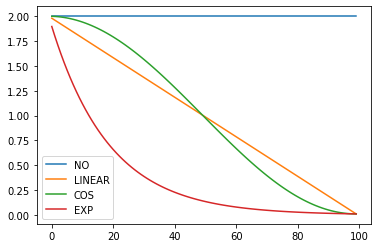

<IPython.core.display.Javascript object>

In [15]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01, 1, 100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In practice, we'll often want to combine different schedulers, the following function does that: it uses `scheds[i]` for `pcts[i]` of the training.

In [16]:
#export
def combine_scheds(pcts, scheds):
    """Combine different scheduler of hyper-parameters during training."""
    assert sum(pcts) == 1.
    pcts = torch.tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        # Determine which scheduler to use
        idx = (pos >= pcts).nonzero().max()
        # Determine the actual position to be used by the chosen scheduler
        actual_pos = (pos - pcts[idx]) / (pcts[idx + 1] - pcts[idx])
        return scheds[idx](actual_pos)

    return _inner

<IPython.core.display.Javascript object>

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [1]:
import torch

In [2]:
x = torch.tensor([0, 0.3, 1.0])

In [11]:
(0.01 >= x)

tensor([ True, False, False])

In [8]:
(0.3 >= x).nonzero()

tensor([[0],
        [1]])

In [7]:
(0.3 >= x).nonzero().max()

tensor(1)

In [17]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

<IPython.core.display.Javascript object>

/Users/imad/anaconda3/envs/dl-zoo/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  # Remove the CWD from sys.path while we load stuff.


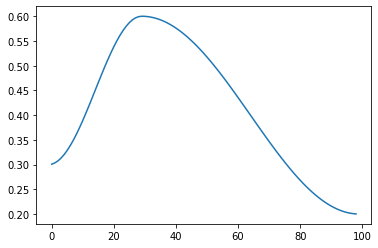

<IPython.core.display.Javascript object>

In [18]:
plt.plot(a[:-1], [sched(o) for o in p[:-1]]);

We can use it for training quite easily...

In [19]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

<IPython.core.display.Javascript object>

In [20]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

<IPython.core.display.Javascript object>

In [21]:
run.fit(3, learn)

train: [0.785811953125, tensor(0.7811)]
valid: [0.314183447265625, tensor(0.9100)]
train: [0.30704419921875, tensor(0.9103)]
valid: [0.2499669677734375, tensor(0.9285)]
train: [0.25111142578125, tensor(0.9280)]
valid: [0.225735205078125, tensor(0.9360)]


<IPython.core.display.Javascript object>

... then check with our recorder if the learning rate followed the right schedule.

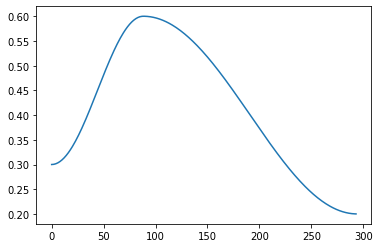

<IPython.core.display.Javascript object>

In [22]:
run.recorder.plot_lr()

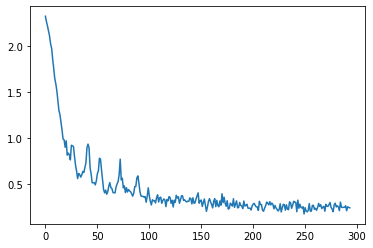

<IPython.core.display.Javascript object>

In [23]:
run.recorder.plot_loss()

## Export

In [24]:
!python ../src/notebook2script.py 05_Anneal-Imad.ipynb

Converted 05_Anneal-Imad.ipynb to exp/nb_05.py


<IPython.core.display.Javascript object>